# Federated PyTorch 3dUNET Tutorial 

 We will use monai brats tutorial as a template 

In [1]:
# Install dependencies if not already installed
!pip install torch
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
import openfl.native as fx

# Setup default workspace, logging, etc. Install additional requirements
fx.init('torch_3dunet_brats')

Creating Workspace Directories
Creating Workspace Templates


/home/maksim/.virtualenvs/brain_tumor/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0



New workspace directory structure:
workspace
├── agg_to_col_one_signed_cert.zip
├── code
│   ├── data_loader.py
│   ├── fed_unet_runner.py
│   ├── pt_unet_parts.py
│   └── __init__.py
├── plan
│   ├── data.yaml
│   ├── plan.yaml
│   ├── cols.yaml
│   └── defaults
│       ├── aggregator.yaml
│       ├── network.yaml
│       ├── assigner.yaml
│       ├── collaborator.yaml
│       ├── tasks_torch.yaml
│       ├── tasks_tensorflow.yaml
│       ├── tasks_keras.yaml
│       ├── tasks_fast_estimator.yaml
│       ├── data_loader.yaml
│       ├── task_runner.yaml
│       └── defaults
├── logs
├── save
│   ├── torch_unet_kvasir_init.pbuf
│   ├── torch_unet_kvasir_last.pbuf
│   └── torch_unet_kvasir_best.pbuf
├── .workspace
├── cert
│   ├── ca
│   │   ├── signing-ca
│   │   ├── signing-ca.csr
│   │   ├── root-ca
│   │   ├── signing-ca.crt
│   │   └── root-ca.crt
│   ├── server
│   │   ├── agg_maksim-thinkpad-t490.key
│   │   ├── agg_none.csr
│   │   ├── agg_maksim-thinkpad-t490.crt
│   │   ├── a

In [3]:
import os
import json
import torch
import matplotlib.pyplot as plt
import numpy as np

from monai.data import DataLoader
from monai.data import CacheDataset
from monai.data import (load_decathlon_datalist )
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.transforms import (
    Activations,
    AsChannelFirstd,
    AsDiscrete,
    CenterSpatialCropd,
    Compose,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    ToTensord,
)

from openfl.federated import FederatedModel, FederatedDataSet
from openfl.utilities import TensorKey

Download BraTS dataset

In [4]:
# !wget -c --tries=0 --retry-connrefused --timeout=2 --wait=1  --continue "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task01_BrainTumour.tar" -O brats.tar
# !tar -xvf brats.tar -C ./data
# !rm ./data/Task01_BrainTumour/imagesTr/.*.nii.gz

Prepare preprocessing function

In [5]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 2 and label 3 to construct TC
            result.append(np.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(
                np.logical_or(
                    np.logical_or(d[key] == 2, d[key] == 3), d[key] == 1
                )
            )
            # label 2 is ET
            result.append(d[key] == 2)
            d[key] = np.stack(result, axis=0).astype(np.float32)
        return d


train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        RandSpatialCropd(
            keys=["image", "label"], roi_size=[128, 128, 64], random_size=False
        ),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=0.5),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=0.5),
        ToTensord(keys=["image", "label"]),
    ]
)

val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CenterSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 64]),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
    ]
)

In [6]:
class BraTSDataset(CacheDataset):
    """
    This dataset contains brain tumor 3d images for one collaborator train or val.
    Args:
        collaborator_count: total number of collaborators
        collaborator_num: number of current collaborator
        is_validation: validation option
        transform: transform function
    """

    def __init__(self, collaborator_count, collaborator_num, is_validation, transform):
        self.is_validation = is_validation
        dataset_dir = './data/Task01_BrainTumour/'

        data = self._generate_data_list(dataset_dir)
        # split all data for current collaborator
        data = data[collaborator_num:: collaborator_count]
        self.is_validation = is_validation
        assert(len(data) > 8)
        validation_size = len(data) // 8
        if is_validation:
            data = data[-validation_size:]
        else:
            data = data[: -validation_size]

        super().__init__(data, transform, cache_num=1, num_workers=4)

    def _generate_data_list(self, dataset_dir):
        datalist = load_decathlon_datalist(os.path.join(
            dataset_dir, "dataset.json"), True, "training")
        return datalist

    # define getitem to get only input and target tensors
    def __getitem__(self, index):
        tmp = super().__getitem__(index)
        print(tmp.keys())
        return (tmp['image'], tmp['label'])

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict'])
dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict'])
image shape: torch.Size([4, 128, 128, 64])


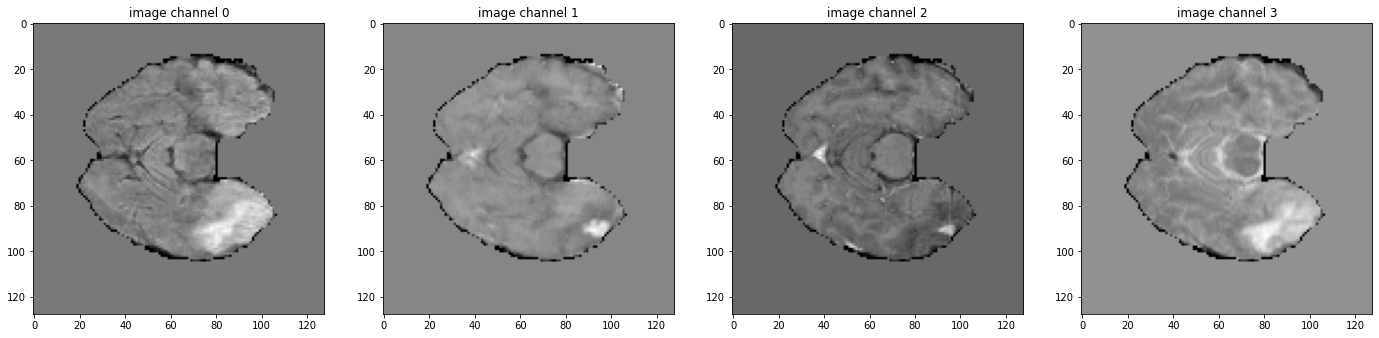

label shape: torch.Size([3, 128, 128, 64])


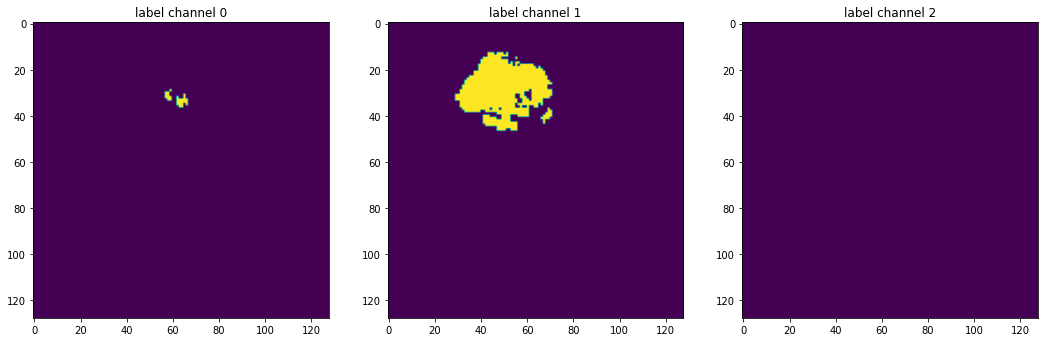

In [7]:


training_s = BraTSDataset(
    1, 0, is_validation=False, transform=train_transform
)
train = training_s[0][0]
val = training_s[0][1]
print(f"image shape: {train.shape}")
plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(train[i, :, :, 20].detach().cpu(), cmap="gray")
plt.show()
# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val.shape}")
plt.figure("label", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(val[i, :, :, 20].detach().cpu())
plt.show()

In [43]:
class BraTSFederatedDataset(FederatedDataSet):
    def __init__(self, collaborator_count=1, collaborator_num=0, batch_size=1, is_split=False, **kwargs):
        """Instantiate the federated data object
        Args:
            collaborator_count: total number of collaborators
            collaborator_num: number of current collaborator
            batch_size:  the batch size of the data loader
            **kwargs: additional arguments, passed to super init
        """
        super().__init__([], [], [], [], batch_size, num_classes=2, **kwargs)

        self.collaborator_num = int(collaborator_num)

        self.batch_size = batch_size

        self.training_set = BraTSDataset(
            collaborator_count, collaborator_num, is_validation=False, transform=train_transform
        )
        self.valid_set = BraTSDataset(
            collaborator_count, collaborator_num, is_validation=True, transform=val_transform
        )

        self.train_loader = self.get_train_loader()
        self.val_loader = self.get_valid_loader()

    def get_valid_loader(self, num_batches=None):
        return DataLoader(self.valid_set, num_workers=2, batch_size=self.batch_size)

    def get_train_loader(self, num_batches=None):
        return DataLoader(
            self.training_set, num_workers=2, batch_size=self.batch_size, shuffle=True
        )

    def get_train_data_size(self):
        return len(self.training_set)

    def get_valid_data_size(self):
        return len(self.valid_set)

    def get_feature_shape(self):
        return self.valid_set[0][0].shape

    def split(self, collaborator_count, shuffle=True, equally=True):
        return [
            BraTSFederatedDataset(collaborator_count,
                                  collaborator_num, self.batch_size)
            for collaborator_num in range(collaborator_count)
        ]

In [ ]:
class UnetWrapper(UNet):
    def __init__(self):
        super().__init__(
            dimensions=3,
            in_channels=4,
            out_channels=3,
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            num_res_units=2,)

    def validate(
        self, col_name, round_num, input_tensor_dict, use_tqdm=False, **kwargs
    ):
        """ Validate. Redifine function from PyTorchTaskRunner, to use our validation"""
        self.rebuild_model(round_num, input_tensor_dict, validation=True)
        loader = self.data_loader.get_valid_loader()
        if use_tqdm:
            loader = tqdm.tqdm(loader, desc="validate")
# -------------Usual validation code---------------------------------------------------------------------------
        self.eval()
        self.to(self.device)
        dice_metric = DiceMetric(include_background=True, reduction="mean")
        post_trans = Compose(
            [Activations(sigmoid=True), AsDiscrete(threshold_values=True)]
        )
        metric_sum = 0.0
        metric_count = 0

        with torch.no_grad():
            for val_inputs, val_labels in loader:

                val_outputs = self(val_inputs)
                val_outputs = post_trans(val_outputs)
                # compute overall mean dice
                value, not_nans = dice_metric(y_pred=val_outputs, y=val_labels)
                not_nans = not_nans.item()
                metric_count += not_nans
                metric_sum += value.item() * not_nans

            metric = metric_sum / metric_count
# --------------------------------------------------------------------------

        origin = col_name
        suffix = "validate"
        if kwargs["apply"] == "local":
            suffix += "_local"
        else:
            suffix += "_agg"
        tags = ("metric", suffix)
        output_tensor_dict = {
            TensorKey("dice_coef", origin, round_num, True, tags): np.array(
                metric
            )
        }
        return output_tensor_dict, {}

# Wrapper, because our train_batches set (output, target) args, but DiceLoss get (input, target)

class DiceLossHeir(DiceLoss):
    __name__ = 'DiceLoss'

    def forward(self, output, target):
        return super().forward(input=output, target=target)


loss_function = DiceLossHeir(
    to_onehot_y=False, sigmoid=True, squared_pred=True)


def optimizer(x): return torch.optim.Adam(
    x, 1e-4, weight_decay=1e-5, amsgrad=True
)

Create BraTSFederatedDataset, federated datasets for collaborators will be created in split() method of this object

In [45]:
fl_data = BraTSFederatedDataset(batch_size=6)

100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


The `FederatedModel` object is a wrapper around your Keras, Tensorflow or PyTorch model that makes it compatible with OpenFL. It provides built-in federated training function which will be used while training. Using its setup function, collaborator models and datasets can be automatically obtained for the experiment.

In [ ]:
fl_model = FederatedModel(build_model=UnetWrapper, optimizer=optimizer,
                          loss_fn=loss_function, data_loader=fl_data)

In [46]:
collaborator_models = fl_model.setup(num_collaborators=2)
collaborators = {'one': collaborator_models[0], 'two': collaborator_models[1]}

100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


We can see the current FL plan values by running the `fx.get_plan()` function

In [4]:
# Get the current values of the FL plan. Each of these can be overridden
print(json.dumps(fx.get_plan(), indent=4, sort_keys=True))

Now we are ready to run our experiment. If we want to pass in custom FL plan settings, we can easily do that with the `override_config` parameter

In [24]:
# Run experiment, return trained FederatedModel
final_fl_model = fx.run_experiment(
    collaborators, override_config={'aggregator.settings.rounds_to_train': 30})

/home/maksim/.virtualenvs/brain_tumor/lib/python3.6/site-packages/openfl/federated/task/runner_pt.py:287: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  new_state[k] = pt.from_numpy(tensor_dict.pop(k)).to(device)


/home/maksim/.virtualenvs/brain_tumor/lib/python3.6/site-packages/openfl/federated/task/runner_pt.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(
/home/maksim/.virtualenvs/brain_tumor/lib/python3.6/site-packages/openfl/federated/task/runner_pt.py:155: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target).to(self.device, dtype=pt.float32)


KeyboardInterrupt: 